In [2]:
#This code is to implement RNN (Recurrent Neural Networks for sentiment analysis)
from keras.layers.recurrent import LSTM
from keras.layers import GRU

from keras.layers.core import Dense, Dropout, SpatialDropout1D, Activation
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import gensim, logging
from keras.optimizers import SGD
from keras.preprocessing import sequence

np.random.seed(42)

/Users/taiwoalabi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
INPUT_FILE = "/Users/taiwoalabi/Downloads/winemag-data-130k-v2.csv"

In [4]:
Marie= pd.read_csv(INPUT_FILE)

In [5]:
#Marie["Feature1"] = []
for ii in range(len(Marie)):
    
    Marie.loc[ii,"Feature1"] = str(Marie.loc[ii,"description"]) + "," + str(Marie.loc[ii,"country"]) + "," + str(Marie.loc[ii,"province"]) \
    + str(Marie.loc[ii,"variety"]) + "," + str(Marie.loc[ii,"winery"])

In [6]:
Adjective_Nouns= ['JJ', 'JJR','JJS','NN', 'NNS', 'NNP', 'NNPS', 'VBN' ]
for ii in range(len(Marie)):
    Z= nltk.pos_tag(nltk.word_tokenize(Marie.loc[ii, "description"]))
    ZZ= [ii[0] for ii in Z if ii[1] in Adjective_Nouns]
    Marie.loc[ii,"POS-Tag"]= ' '.join(ZZ)

In [7]:
VOCAB_SIZE = 5000
EMBED_SIZE = 500
NUM_FILTERS = 1024
NUM_WORDS = 70
BATCH_SIZE = 100
NUM_EPOCHS = 10

In [8]:
counter = collections.Counter()
maxlen = 0
for iii in range(len(Marie)):
    sentence = Marie['POS-Tag'][iii]
    words = [x.lower() for x in nltk.word_tokenize(sentence)]
    
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1

In [9]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_size = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

In [10]:
for ii in range(len(Marie)):
    Marie.loc[ii,"Points1"] = int(Marie.loc[ii,"points"])/100

In [11]:
xs, ys = [], []

for iii in range(len(Marie)):
    sentence = Marie['POS-Tag'][iii]
    label = float(Marie['Points1'][iii])
    words = [x.lower() for x in nltk.word_tokenize(sentence)]
    ys.append((label))
    wids = [word2index[word] for word in words]
    xs.append(wids)

X = pad_sequences(xs, maxlen=maxlen)




In [12]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, ys, test_size=0.3, random_state=50)

In [13]:
#Bidirectional LSTM improve accuracy
from keras.layers.wrappers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.constraints import maxnorm



HIDDEN_LAYER_SIZE = 500




model = Sequential()
model.add(Embedding(vocab_size, EMBED_SIZE,input_length=maxlen))
model.add(SpatialDropout1D(0.3))
model.add(GRU(HIDDEN_LAYER_SIZE, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(HIDDEN_LAYER_SIZE, return_sequences=False))
#model.add(TimeDistributed(Dense(1)))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(1))


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 71, 500)           2500500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 71, 500)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 71, 500)           1501500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 71, 500)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 500)               1501500   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               256512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [31]:
from keras import optimizers
NUM_EPOCHS = 4
lr = 0.001
decay = lr/NUM_EPOCHS
sgd = optimizers.SGD(lr= lr, decay=decay, momentum = 0.9, nesterov = False)

In [32]:
import keras.backend as K
def RawDiff(y_true, y_pred):
    return ((y_pred)- (y_true))

In [33]:
model.compile(loss="mean_squared_error", optimizer=sgd, metrics=["mae", "acc", RawDiff])
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, Ytest))

scores = model.evaluate(Xtest, Ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[2]*100))

Train on 90979 samples, validate on 38992 samples
Epoch 1/4
90979/90979 [==============================] - 1489s 16ms/step - loss: 0.0026 - mean_absolute_error: 0.0404 - acc: 1.6487e-04 - RawDiff: -0.0037 - val_loss: 9.4702e-04 - val_mean_absolute_error: 0.0248 - val_acc: 1.0259e-04 - val_RawDiff: -0.0043
Epoch 2/4
90979/90979 [==============================] - 1479s 16ms/step - loss: 0.0020 - mean_absolute_error: 0.0358 - acc: 1.6487e-04 - RawDiff: -0.0026 - val_loss: 9.3187e-04 - val_mean_absolute_error: 0.0246 - val_acc: 1.0259e-04 - val_RawDiff: -0.0035
Epoch 3/4
90979/90979 [==============================] - 1483s 16ms/step - loss: 0.0017 - mean_absolute_error: 0.0333 - acc: 1.6487e-04 - RawDiff: -0.0020 - val_loss: 9.3614e-04 - val_mean_absolute_error: 0.0247 - val_acc: 1.0259e-04 - val_RawDiff: -0.0046
Epoch 4/4
90979/90979 [==============================] - 1517s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0319 - acc: 1.6487e-04 - RawDiff: -0.0017 - val_loss: 9.2317e-04 -

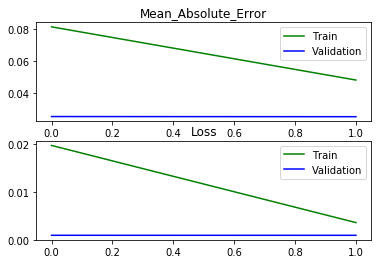

In [17]:
plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")


plt.subplot(211)
plt.title("Mean_Absolute_Error")
plt.plot(history.history["mean_absolute_error"], color="g", label="Train")
plt.plot(history.history["val_mean_absolute_error"], color="b", label="Validation")
plt.legend(loc="best")

#plt.tight_layout()
plt.show()

### This is for Prediction ###

In [34]:
y_pred = model.predict(Xtest)

In [35]:
Absolute_Raw=[]
Code=[]

for ii in range(len(Xtest)):

    Absolute_Raw.append(abs(y_pred[ii]-Ytest[ii]))
    Code.append(ii)
    
Resorted = sorted(Absolute_Raw)

In [37]:
Index_Value= []
for ii in range(len(Resorted)):
    Index_Value.append(Absolute_Raw.index(Resorted[ii]))
    

In [39]:
for ii in range(10):
    print (Xtest[Index_Value[ii]], "With Score: ", Resorted[ii])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  396    5  135   21   24  134  143  194  224  181  636  128    2
  225   11   24   10  346  249    7   16   73  371   87 3401  203  266
   35] With Score:  [4.172325e-07]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  396    5  135   21   24  134  143  194  224  181  636  128    2
  225   11   24   10  346  249    7   16   73  371   87 3401  203  266
   35] With Score:  [4.172325e-07]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

In [40]:
for ii in range(10):
    print (Marie.loc[Index_Value[ii],"POS-Tag"], "With Score: ", Resorted[ii])

off-dry wine offers fresh acidity delicious hints honey yellow fruits fruity rich full typical freshness young Chenin Blanc wine round With Score:  [4.172325e-07]
off-dry wine offers fresh acidity delicious hints honey yellow fruits fruity rich full typical freshness young Chenin Blanc wine round With Score:  [4.172325e-07]
ripe jammy blackberries cherries dark chocolate soft tannic Cabernet alcohol noticeable heat finish rich glycerols Drink With Score:  [8.34465e-07]
Ripe black-skinned fruit underbrush earth whiff crushed herb solid red round palate juicy wild cherry raspberry compote cinnamon hint vanilla anise robust velvety tannins muscle polish note grilled sage finish With Score:  [1.5497208e-06]
Light color full fruit ripe jammy wine good core tannins surrounded ripe cherry strawberry-flavored fruits good future dense wine With Score:  [3.7550926e-06]
Rich structured complex wine grand cru vines northern slopes Montagne Reims tense packed ripe apple pineapple fruit flavors tens

In [49]:
Worst= Resorted[-10:]

In [50]:
Worst

[array([0.10833836], dtype=float32),
 array([0.10946953], dtype=float32),
 array([0.10983503], dtype=float32),
 array([0.11022288], dtype=float32),
 array([0.11216962], dtype=float32),
 array([0.11296666], dtype=float32),
 array([0.11411142], dtype=float32),
 array([0.11612612], dtype=float32),
 array([0.11622584], dtype=float32),
 array([0.11628902], dtype=float32)]

In [51]:
Index_Value= []
for ii in range(len(Worst)):
    Index_Value.append(Absolute_Raw.index(Worst[ii]))

In [52]:
for ii in range(10):
    print (Marie.loc[Index_Value[ii],"POS-Tag"], "With Score: ", Worst[ii])

blend Sangiovese Malbec Cabernet Sauvignon Petite Sirah other varieties wealth ripe dusty black fruit richly round soft palate approachable oaked With Score:  [0.10833836]
Dark full-bodied dry Syrah bit rustic sharp acidity blackberry fruit pepper great deal complexity solid red wine drinking hearty meats stews With Score:  [0.10946953]
grabs attention dark color potent jam brown sugar aromas Next come dazzling strawberry syrup flavors backed thick tannins good acidity texture astringent tight flavors full tannins way Best With Score:  [0.10983503]
good Sauvignon Blanc clean crisp sweet lemon lime vanilla flavors brightened zesty acidity Easy roast chicken With Score:  [0.11022288]
62-year-old dry-farmed vines Esola Zinfandel leathery full tobacco dust surrounded spicy red fruit great structure savoriness soft light finish grace years With Score:  [0.11216962]
distinctive white combination spice tropical fruit chalky backbone wine elegant ageable fans classic French whites Chablis Pair

In [54]:
for ii in range(10):
    print (Marie.loc[Index_Value[ii],"description"], "With Score: ", Worst[ii], "\n")

This blend of Sangiovese, Malbec, Cabernet Sauvignon, Petite Sirah and other varieties plays well to type. It shows a wealth of ripe, dusty black fruit that's richly round and soft on the palate, approachable and lightly oaked. With Score:  [0.10833836] 

Dark, full-bodied and dry, this Syrah is a bit rustic, with some sharp acidity accompanying the blackberry fruit and pepper. Doesn't show a great deal of complexity, but it's a solid red wine for drinking now with hearty meats or stews. With Score:  [0.10946953] 

This grabs attention quickly, with a dark color and potent jam and brown sugar aromas. Next come dazzling strawberry syrup flavors backed by thick tannins and good acidity. The texture is astringent and tight, but the flavors are so full that they meet the tannins half way. Best now through 2019. With Score:  [0.10983503] 

A good Sauvignon Blanc, clean and crisp, with slightly sweet lemon, lime and vanilla flavors, brightened by zesty acidity. Easy to drink with roast chick